In [29]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.despine()
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
import os
import theano

<Figure size 432x288 with 0 Axes>

In [30]:
theano.config.compute_test_value = "ignore"

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

'''config = tf.ConfigProto()
config.gpu_options.allow_growth  =True
tf.keras.backend.set_session(tf.Session(config=config))'''


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.85):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]

    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test






In [31]:
data = pd.read_csv('~/Desktop/EURUSD.csv')
data = data['Close'][data.index[-5000:]]
data = data.tolist()

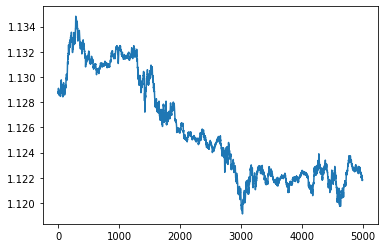

In [32]:
# Uncomment below to use price change time series
# data = data.ix[:, 'Close'].pct_change().dropna().tolist()

plt.plot(data)

In [33]:
WINDOW = 1000
EMB_SIZE = 1
STEP = 1
FORECAST = 30

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i + WINDOW]
        y_i = data[i + WINDOW + FORECAST]

        last_close = x_i[WINDOW - 1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1]

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]  # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)



list index out of range


In [34]:
'''model =Sequential()
model.add(LSTM(500,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.8))
model.add(Dense(2))
model.add(Activation('softmax'))'''

model = Sequential()
model.add(Dense(500, input_dim=1000,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(250,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(50,
                activity_regularizer=regularizers.l2(0.01)))

model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)

model.compile(optimizer=opt,
              loss='logcosh',
              metrics=['accuracy'])



history = model.fit(X_train, Y_train,
                    epochs=50,
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr],
                    shuffle=True)





Epoch 1/50
27/27 [==============================] - 1s 27ms/step - loss: 3.2252 - accuracy: 0.5708 - val_loss: 2.6819 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 1.9022 - accuracy: 0.6280 - val_loss: 2.0014 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 1s 23ms/step - loss: 1.5429 - accuracy: 0.6672 - val_loss: 1.7247 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 1.3119 - accuracy: 0.6778 - val_loss: 1.5364 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 1s 24ms/step - loss: 1.1624 - accuracy: 0.6891 - val_loss: 1.3800 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 1s 24ms/step - loss: 1.0280 - accuracy: 0.6864 - val_loss: 1.2633 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 1s 24ms/step - loss: 0.9

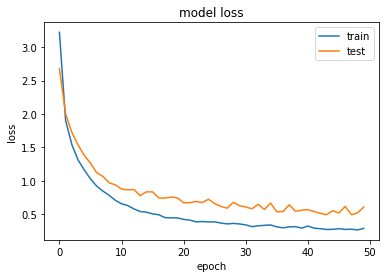

In [35]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print (C / C.astype(np.float).sum(axis=1))

[[0.46953405 0.46687697]
 [0.62007168 0.45425868]]


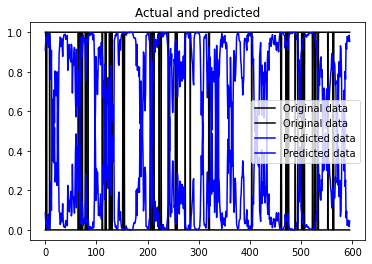

In [42]:
plt.plot(Y_test, color='black', label='Original data')
plt.plot(pred, color='blue', label='Predicted data')
plt.legend(loc='right')
plt.title('Actual and predicted')
plt.show()